# Pneumonia X-Ray Image Classification: Visualizations

This notebook contains visualizations generated for the presentation slides and notebooks. Other visualization functions are contained in the `visualizations.py` file in `tools`.

In [1]:
import os
import sys
import pickle
import cv2

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator,\
array_to_img,\
img_to_array,\
load_img

from tensorflow.keras.models import load_model

import tools.visualizations as vis
import tools.misc as misc

In [2]:
# Downloaded imports

# pip install focal-loss
from focal_loss import BinaryFocalLoss

In [3]:
# Path Constants
TRAIN_PATH = 'data/split/train'
VAL_PATH = 'data/split/val'
TEST_PATH = 'data/split/test'

# Image Processing Constants
BATCH_SIZE = 32
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Change for test runs
EPOCHS = 30

In [4]:
# Call function to display counts and return dict of subtotals
counts = misc.count_files([TRAIN_PATH, VAL_PATH, TEST_PATH])
print('\n',counts)

TRAIN
-------------------------
	PNEUMONIA: 2564
	NORMAL: 950

	SUBTOTAL: 3514
VAL
-------------------------
	PNEUMONIA: 855
	NORMAL: 317

	SUBTOTAL: 1172
TEST
-------------------------
	PNEUMONIA: 854
	NORMAL: 316

	SUBTOTAL: 1170
-------------------------
TOTAL: 5856 files

 {'train': 3514, 'val': 1172, 'test': 1170}


In [5]:
# DirectoryIterator parameters for flow_from_directory
gen_params = {
    'target_size': (IMAGE_HEIGHT, IMAGE_WIDTH),
    'color_mode': 'grayscale',
    'class_mode': 'binary',
}

In [6]:
# Load data as was done in the modeling notebok
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TRAIN_PATH, 
    batch_size=counts['train'],
    **gen_params
)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    VAL_PATH, 
    batch_size=counts['val'],
    **gen_params
)

# Get all the data in the directory data/test (854+316 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_PATH,
    batch_size=counts['test'],
    **gen_params
)

Found 3514 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


In [7]:
# Create the datasets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [8]:
# Load models and their histories
model1 = load_model('models/model1.h5')
model2 = load_model('models/model2.h5')
model3 = load_model('models/model3.h5')
model4 = load_model('models/model4.h5')
model4_1 = load_model('models/model4_1.h5')
model5 = load_model('models/model5.h5')

hist1 = misc.unpickle_history('models/model1_hist.pkl')
hist2 = misc.unpickle_history('models/model2_hist.pkl')
hist3 = misc.unpickle_history('models/model3_hist.pkl')
hist4 = misc.unpickle_history('models/model4_hist.pkl')
hist4_1 = misc.unpickle_history('models/model4_1_hist.pkl')
hist5 = misc.unpickle_history('models/model5_hist.pkl')

In [9]:
# Define lists of models, their names, and their histories
names = [
    'Model 1',
    'Model 2',
    'Model 3',
    'Model 4',
    'Model 5',
    'Model 6'
]

models = [
    model1,
    model2,
    model3,
    model4,
    model4_1,
    model5
]

histories = [
    hist1,
    hist2,
    hist3,
    hist4,
    hist4_1,
    hist5
]

In [10]:
# Create lists of accuracies
accs = [hist['acc'][-1] for hist in histories]
val_accs = [hist['val_acc'][-1] for hist in histories]
test_accs = [model.evaluate(test_images, test_labels)[1] for model in models]

37/37 [==============================] - 1s 16ms/step - loss: 0.0624 - acc: 0.9060


In [11]:
recs = []
val_recs = []
test_recs = []
for model in models:
    train_preds = (model.predict(train_images) > 0.5).astype('int32')
    val_preds = (model.predict(val_images) > 0.5).astype('int32')
    test_preds = (model.predict(test_images) > 0.5).astype('int32')

    rec = recall_score(train_labels, train_preds)
    val_rec = recall_score(val_labels, val_preds)
    test_rec = recall_score(test_labels, test_preds)

    recs.append(recall_score(train_labels, train_preds))
    val_recs.append(recall_score(val_labels, val_preds))
    test_recs.append(recall_score(test_labels, test_preds))

In [12]:
# Create DataFrame for easier plotting
acc_data = {
    'Model': names,
    'Training Accuracy': accs,
    'Validation Accuracy': val_accs,
    'Testing Accuracy': test_accs,
}
rec_data = {
    'Model': names,
    'Training Recall': recs,
    'Validation Recall': val_recs,
    'Testing Recall': test_recs
}
acc_df = pd.DataFrame(acc_data)
rec_df = pd.DataFrame(rec_data)

display(acc_df, rec_df)

,Model,Training Accuracy,Validation Accuracy,Testing Accuracy
0,Model 1,0.940239,0.921502,0.913675
1,Model 2,0.945931,0.930034,0.933333
2,Model 3,0.936255,0.922355,0.912821
3,Model 4,0.942516,0.934300,0.934188
4,Model 5,0.940808,0.938567,0.942735
5,Model 6,0.924872,0.909556,0.905983


,Model,Training Recall,Validation Recall,Testing Recall
0,Model 1,0.991420,0.982456,0.976581
1,Model 2,0.962949,0.949708,0.946136
2,Model 3,0.990250,0.984795,0.976581
3,Model 4,0.983229,0.978947,0.968384
4,Model 5,0.965289,0.955556,0.951991
5,Model 6,0.985179,0.973099,0.967213


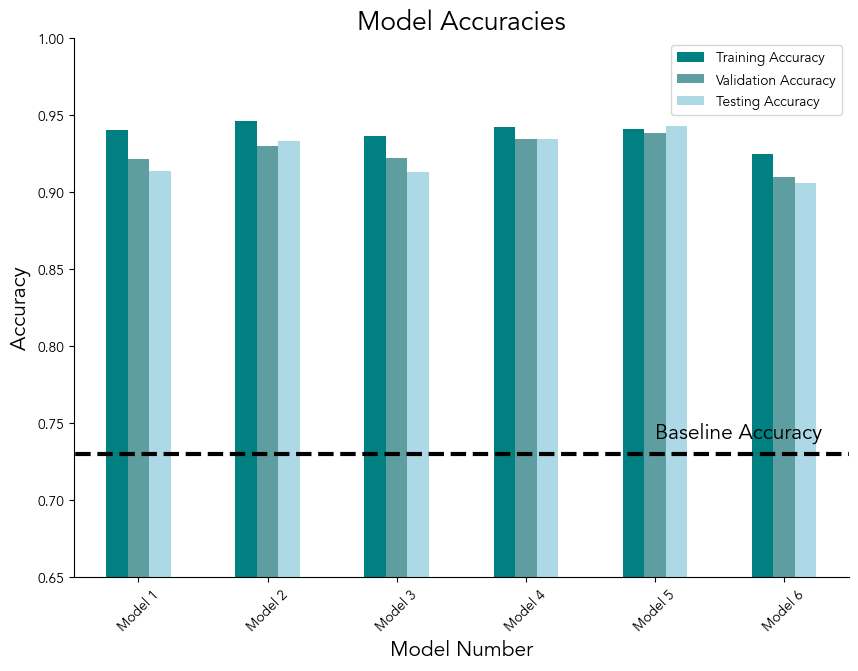

In [13]:
# Plot bar chart with training, validation, and testing accuracies for each model
with plt.style.context('images/presentation.mplstyle'):
    acc_df.set_index('Model').plot.bar(color=['teal', 'cadetblue', 'lightblue'])
    
    # Baseline 73 % accuracy
    plt.hlines(y=.73, xmin=-1, xmax=10, linestyles='dashed', colors='black')
    plt.text(4, 0.74, 'Baseline Accuracy', fontsize=15, fontweight='bold')
    plt.ylim(0.65, 1.0)
    plt.xticks(rotation=45)
    plt.title('Model Accuracies')
    plt.xlabel('Model Number')
    plt.ylabel('Accuracy')
    plt.savefig('images/acc_barplot.png')
    plt.show()

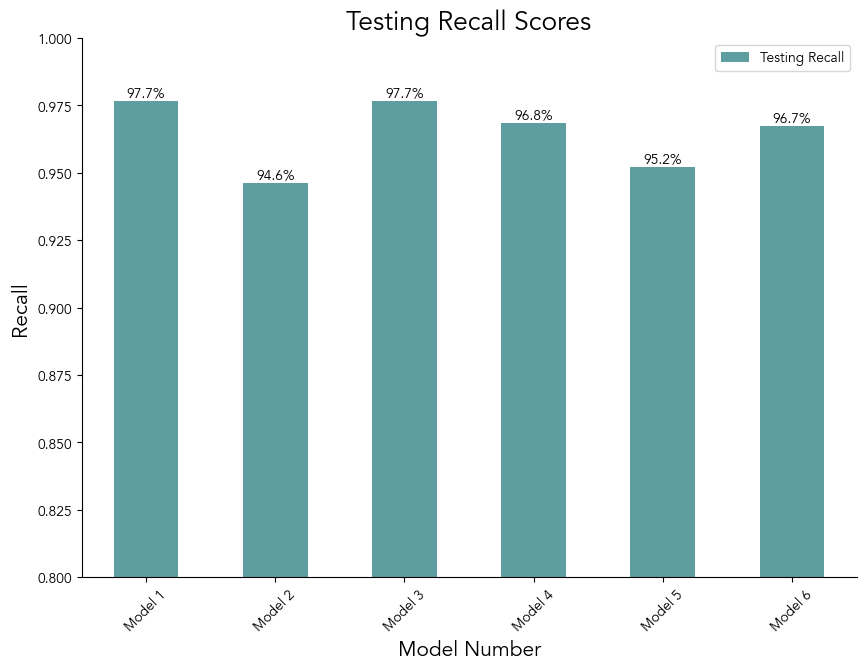

In [14]:
with plt.style.context('images/presentation.mplstyle'):
    ax = rec_df.set_index('Model').plot.bar(y='Testing Recall', color='cadetblue')
    plt.ylim(0.8, 1.0)
    plt.xticks(rotation=45)
    plt.title('Testing Recall Scores')
    plt.xlabel('Model Number')
    plt.ylabel('Recall')
    
    rects = ax.patches
    labels = [f'{test_rec:.1%}' for test_rec in test_recs]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        plt.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    
    plt.savefig('images/recall_barplot.png')
    plt.show();

#### Sample Images

In [15]:
vir_samples = [
    'data/VIRUS/person1_virus_11.jpeg',
    'data/VIRUS/person1_virus_12.jpeg',
    'data/VIRUS/person1_virus_13.jpeg',
]

bac_samples = [
    'data/BACTERIA/person1_bacteria_1.jpeg',
    'data/BACTERIA/person1_bacteria_2.jpeg',
    'data/BACTERIA/person10_bacteria_43.jpeg'
]

norm_samples = [
    'data/NORMAL/IM-0001-0001.jpeg',
    'data/NORMAL/IM-0001-0001.jpeg',
    'data/NORMAL/IM-0001-0001.jpeg'
]

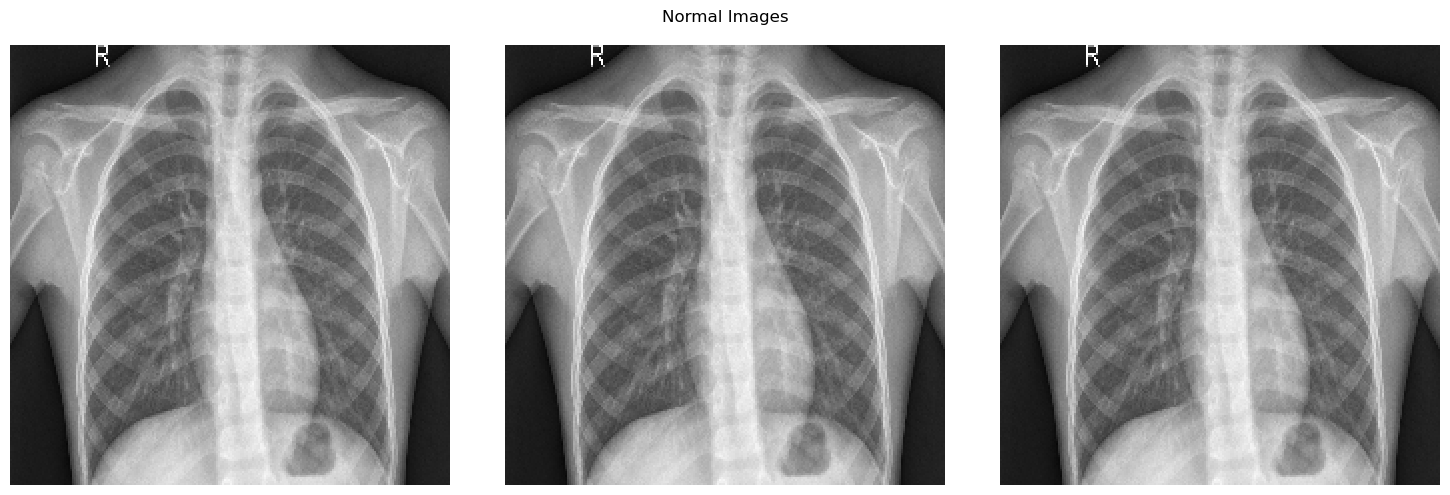

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(norm_samples[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
fig.suptitle("Normal Images")
fig.tight_layout()       
plt.savefig('images/norm_samples.png')
plt.show()

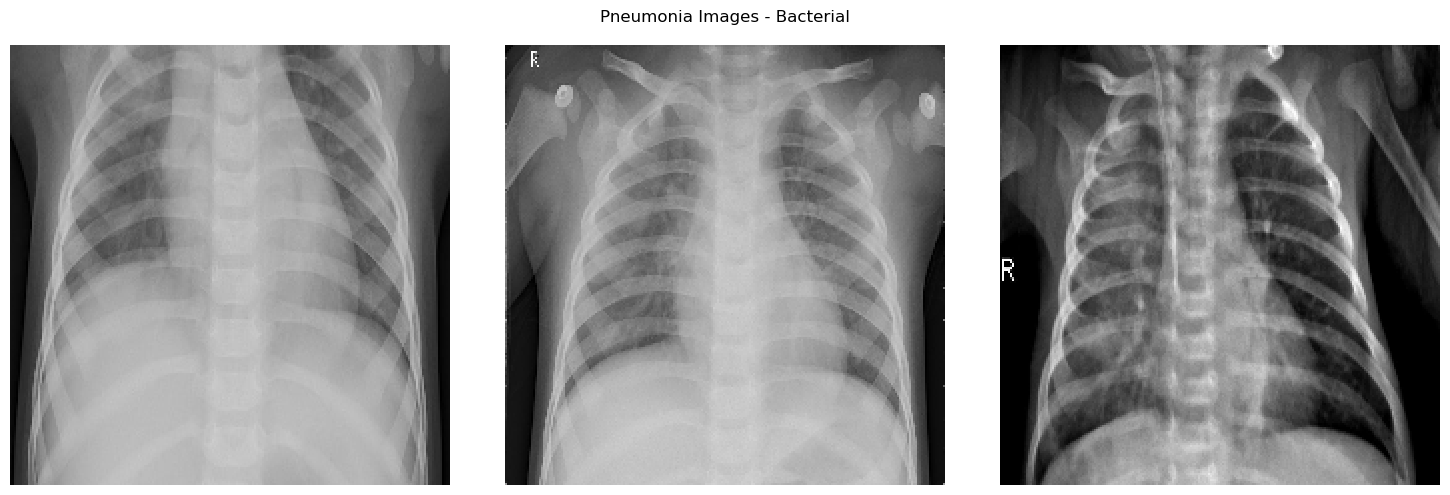

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(bac_samples[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
fig.suptitle("Pneumonia Images - Bacterial")
fig.tight_layout()
plt.savefig('images/bac_samples.png')
plt.show()

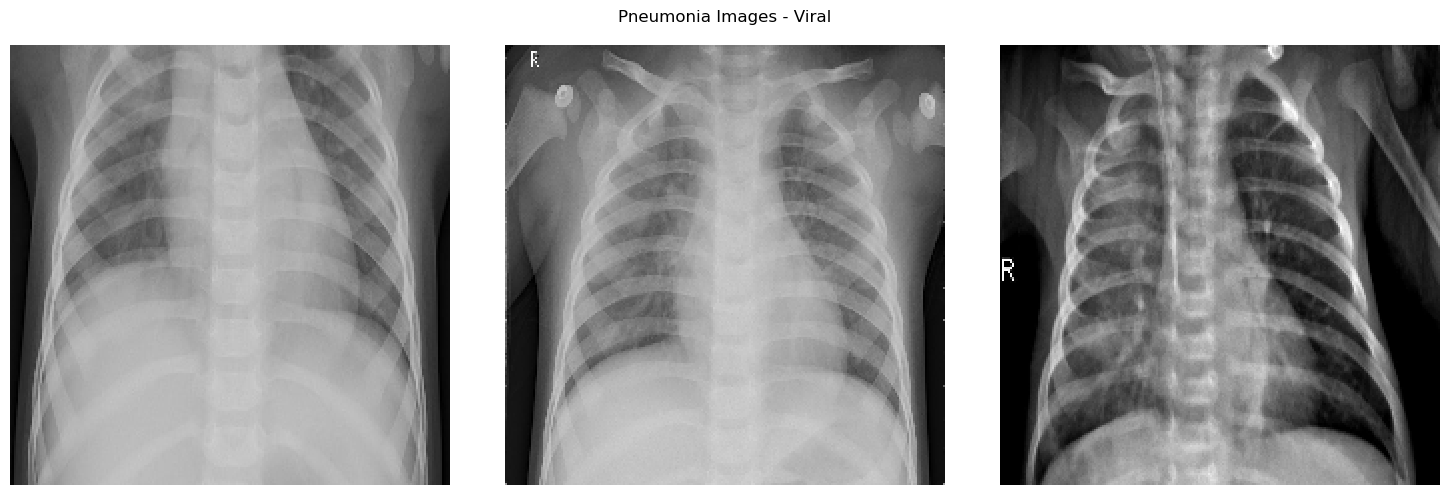

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(bac_samples[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
fig.suptitle("Pneumonia Images - Viral")
fig.tight_layout()
plt.savefig('images/vir_samples.png')
plt.show()